<a href="https://colab.research.google.com/github/kozyreviva/Data_Science/blob/main/numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Загрузим необходимые библиотеки.

In [ ]:
#загрузка библиотек
import pandas as pd
import numpy as np
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

Сохраним датафрейм в переменную.

In [ ]:
#загрузка датафрейма
df = pd.read_csv("/datasets/autos.csv")

Проверим содержание датафрейма

In [ ]:
#вывод таблицы
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [ ]:
#Вывод формы
df.shape

(354369, 16)

In [ ]:
#вывод информации
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Краткие выводы:**  
В датафрейме присутствуют пропуски и неинформативные столбцы.
Также датафрейм имеет столбцы с категориальными данными типа object, что может вызвать затреднение в обученнии модели.
В столбце цены можно увидеть нулевые значения что можно считаль аномалией. Надо определить порог цены и улалить строки ниже порогового значения.

Проверим значения столбца Price.

In [ ]:
#вывод значений
df["Price"].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

Видно что нулевых значений очень много, это аномальные значения.Определим разумный порог цены и удалим строки ниже этого порога.  
Заодно удалим неинформативные столбцы.

In [ ]:
#удаление строк ниже порогового значения
df = df.drop(df.query('Price < 1500').index)
#удаление неинформативных столбцов
df = df.drop(["DateCrawled","RegistrationMonth","DateCreated","NumberOfPictures","PostalCode","LastSeen"],axis = 1)

Проверим пропуски в столбцах.

In [ ]:
#вывод количества пропусков
df.isna().sum()

Price                   0
VehicleType         16169
RegistrationYear        0
Gearbox              8367
Power                   0
Model                9444
Kilometer               0
FuelType            13704
Brand                   0
NotRepaired         33993
dtype: int64

Видно что столбцы содержащие пропуски имеют категориальные переменный типа object.  
Т.к. значения объектовые и заполнение пропусков подходящими значениями затруднителен, то применим заглушку для каждого из столбцов. 

In [ ]:
#заполнение пропусков
df[["VehicleType","Gearbox","Model","FuelType","NotRepaired"]] = df[["VehicleType","Gearbox","Model","FuelType","NotRepaired"]].fillna("Unknown")

In [ ]:
#проверка на наличие пропусков
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

В столбцах RegistrationYear и Power присутствуют аномальные значения, исправим их.

In [ ]:
#выбросы исправляем на медианное значение
Q1 =  df['RegistrationYear'].quantile(0.25)
Q3 = df['RegistrationYear'].quantile(0.75)
IQR = Q3 - Q1
(df.loc[(df['RegistrationYear'] < Q1-1.5*IQR ) | (df['RegistrationYear'] > Q3+1.5*IQR),
        ['RegistrationYear']]) = df["RegistrationYear"].median()

In [ ]:
#выбросы исправляем на медиaнное значение
Q1 =  df['Power'].quantile(0.25)
Q3 = df['Power'].quantile(0.75)
IQR = Q3 - Q1
(df.loc[(df['Power'] < Q1-1.5*IQR ) | (df['Power'] > Q3+1.5*IQR),
        ['Power']]) = df["Power"].median()
df.loc[df["Power"]< 50,["Power"]] = df["Power"].median()

Применим порядковое кодирование для перевода объектовых значений в числовые.

In [ ]:
# код ревьюера

df.describe()

,Price,RegistrationYear,Power,Kilometer
count,238013.000000,238013.000000,238013.000000,238013.000000
mean,6227.769966,2005.509695,126.619874,123970.035250
std,4500.906613,5.065233,42.656028,39163.706657
min,1500.000000,1992.000000,50.000000,5000.000000
25%,2699.000000,2002.000000,101.000000,100000.000000
50%,4700.000000,2005.000000,118.000000,150000.000000
75%,8500.000000,2009.000000,150.000000,150000.000000
max,20000.000000,2019.000000,258.000000,150000.000000


In [ ]:
#кодирование данных
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)

Выведем новый датафрейм.

In [ ]:
#вывод таблицы
df_ordinal.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,2891.0,3.0,19.0,2.0,140.0,26.0,11.0,3.0,1.0,2.0
1,1894.0,7.0,12.0,1.0,113.0,117.0,11.0,3.0,14.0,0.0
2,0.0,6.0,9.0,2.0,25.0,116.0,12.0,7.0,38.0,1.0
3,637.0,6.0,16.0,2.0,19.0,101.0,9.0,3.0,31.0,1.0
4,227.0,2.0,12.0,2.0,59.0,8.0,12.0,7.0,25.0,1.0


Чтобы избежать мультиколлинеарности проверим признаки на корреляцию.
Пороговое значение 0.7.

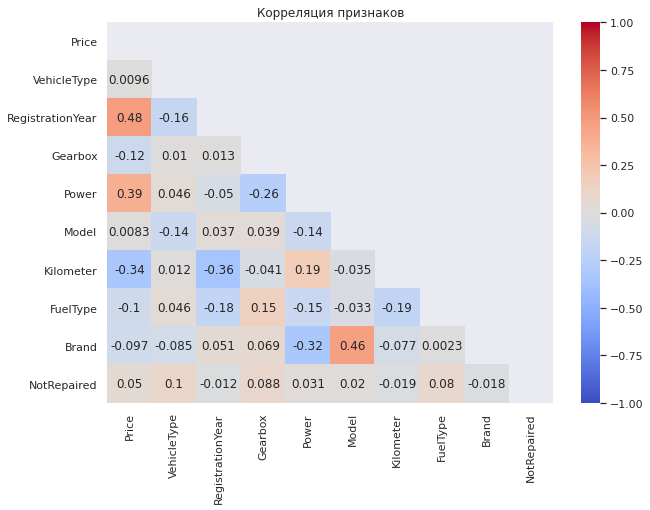

In [ ]:
#выделим значения для сокрытия их в тепловой карте
upp_mat = np.triu(df_ordinal.corr())
#построение тепловой карты корреляции признаков
sns.set(rc = {'figure.figsize':(10,7)})
sns.heatmap(df_ordinal.corr(),vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)
plt.title("Корреляция признаков")
plt.show()

Видим что корреляция между признаками не сильная.


Т.к значения в таблице целые то переведём их в тип int

In [ ]:
#смена типа данных
df_ordinal = df_ordinal.astype(int)

Разделим датафрейм на признаки и целевой признак.

In [ ]:
#запись признаков в переменные
features = df_ordinal.drop("Price", axis = 1)
target = df_ordinal.Price

Разделим признаки на выборки. Обучающую и тестовую.

In [ ]:
#разделение на выборки
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            test_size = 0.25,
                                                                          random_state = 12345)

## Обучение моделей

Обучим несколько моделей и посмотрим на время работы ячейки. Для оценки качества применим метрику RMSE

In [ ]:
%%time
#модель случайного леса
model_tree = DecisionTreeRegressor(random_state = 12345)

params = [{"max_depth": np.arange(1,21,2)}]
gs_tree = GridSearchCV(estimator = model_tree,
                      param_grid=params,
                      scoring="neg_root_mean_squared_error",
                      cv=4)
gs_tree.fit(features_train, target_train)
print("дерево решений")
print(gs_tree.best_params_)
print(abs(gs_tree.score(features_train, target_train)))

дерево решений
{'max_depth': 15}
307.1897279259707
CPU times: user 10.7 s, sys: 59.3 ms, total: 10.8 s
Wall time: 10.8 s


In [ ]:
%%time
#модель случайного леса
model_rf = RandomForestRegressor(random_state = 12345)

params = [{"n_estimators": np.arange(10,51,10),
      "max_depth": np.arange(1,16,2)}]
gs_rf = GridSearchCV(estimator = model_rf,
                      param_grid=params,
                      scoring="neg_root_mean_squared_error",
                      cv=4)
gs_rf.fit(features_train, target_train)
print("Рандомынй лес")
print(gs_rf.best_params_)
print(abs(gs_rf.score(features_train, target_train)))

Рандомынй лес
{'max_depth': 15, 'n_estimators': 50}
285.4630317489089
CPU times: user 11min 10s, sys: 3.24 s, total: 11min 13s
Wall time: 11min 14s


In [ ]:
%%time
#модель линейной регрессии
model = LinearRegression()

# < посчитайте оценки, вызвав функцию cross_value_score с пятью блоками >
scores = cross_val_score(model, 
                         features_train.values, 
                         target_train.values, 
                         cv = 4,
                         scoring = "neg_root_mean_squared_error")
final_score = scores.mean()
print("Линейная регрессия")
print(abs(final_score))

Линейная регрессия
600.4577717525176
CPU times: user 384 ms, sys: 224 ms, total: 607 ms
Wall time: 593 ms


In [ ]:
%%time
#модель случайного леса
model_LGBM = LGBMRegressor()

params = [{"n_estimators": np.arange(10,51,10),
      "max_depth": np.arange(1,21,2)}]
gs_LGBM = GridSearchCV(estimator = model_LGBM,
                      param_grid=params,
                      scoring="neg_root_mean_squared_error",
                      cv=4)
gs_LGBM.fit(features_train, target_train)
print("LightGBM")
print(gs_LGBM.best_params_)
print(abs(gs_LGBM.score(features_train, target_train)))

## Анализ моделей

Проверим качество моделей на тестовой выборке.

In [ ]:
#оценка качества дерева решений
predictions = gs_tree.predict(features_test)
rmse = sqrt(mean_squared_error(target_test,predictions))

print("Дерево решений")
print("RMSE:",rmse)

In [ ]:
#оценка качества рандомного леса
predictions = gs_rf.predict(features_test)
rmse = sqrt(mean_squared_error(target_test,predictions))

print("Рандомный лес")
print("RMSE:",rmse)

In [ ]:
#оценка качества LightGBM
predictions = gs_LGBM.predict(features_test)
rmse = sqrt(mean_squared_error(target_test,predictions))

print("LightGBM")
print("RMSE:",rmse)

Обучив модели и проверив их качество на тестовых выборках, можно сказать что порой градиентный бустинг не всегда эффективен в плане времени выполнения кода. 